In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

pd.set_option('future.no_silent_downcasting', True)

## 1. Preparing datasets

### Real dataset

In [2]:
banana_df = pd.read_csv('./data/banana_quality.csv')
banana_df.replace({'Quality': {'Good': 1, 'Bad': 0}}, inplace=True)
banana_df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,1
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,1
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,1
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,1
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,1


### Artificial dataset

In [3]:
n_observations = 1000
b = 1
k = 20

In [4]:
n_features = 5 + k

betas = np.array([b] * 5 + [0] * k)

X = np.zeros((n_observations, n_features))
y = np.zeros(n_observations)

for n in range(n_observations):
    x_list = np.array([np.random.normal() for _ in range(n_features)])
    p = 1 / (1 + np.exp(-(np.matmul(betas.transpose(), x_list))))
    label = np.random.binomial(n=1, p=p)
    
    X[n] = x_list
    y[n] = label

In [5]:
X.shape

(1000, 25)

In [6]:
y.shape

(1000,)

## 2. Classification models

### Classificaiton error

In [7]:
def calculate_classification_error(predictions, y_test):
    classificaiton_error = 0
    for y_pred, y in zip(predictions, y_test):
        if y_pred != y:
            classificaiton_error += 1 
    return classificaiton_error/len(y_test)

### Models

In [8]:
def create_models():
    return {
        'logistic_regression': LogisticRegression(penalty='l2'),
        'classification_tree': DecisionTreeClassifier(random_state=0)
    }

## 3. Performance of the models

### 3.1 on artificial dataset

* Refitting (whole dataset for both training and testing)

In [17]:
def refitting_evaluation(X, y):
    X_train, X_test, y_train, y_test = X, X, y, y
    
    errors = {}
    models = create_models()

    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        errors[name] = calculate_classification_error(predictions, y_test)

    return errors

refitting_evaluation(X, y)

{'logistic_regression': 0.2, 'classification_tree': 0.0}

* 10 fold Cross validation

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import zero_one_loss


errors = {}
models = create_models()

for name, model in models.items():
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    classification_errors = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        error = calculate_classification_error(y_pred, y_test)
        classification_errors.append(error)
        
    errors[name] = np.mean(classification_errors)

    
errors

{'logistic_regression': 0.227, 'classification_tree': 0.374}

* bootstrap method

In [13]:
from sklearn.utils import resample
from scipy.stats import bootstrap

# Set the number of bootstrap samples
n_iterations = 10
n_size = len(X)

classification_errors = []

for name, model in models.items():
# Perform bootstrap sampling

    classification_errors = []

    for i in range(n_iterations):
        # Generate a bootstrap sample
        X_resampled, y_resampled = resample(X, y, n_samples=n_size, replace=True, random_state=i)
        
        in_bag_indices = np.unique(resample(np.arange(n_size), n_samples=n_size, replace=True, random_state=i))
        oob_indices = np.setdiff1d(np.arange(n_size), in_bag_indices)
        X_oob, y_oob = X[oob_indices], y[oob_indices]
        
        # Train the classifier on the bootstrap sample
        model.fit(X_resampled, y_resampled)
        
        # Predict the labels for the OOB samples
        y_pred = model.predict(X_oob)
        
        # Calculate the classification error
        error = calculate_classification_error(y_pred, y_oob)
        classification_errors.append(error)
            
    errors[name] = np.mean(classification_errors)

errors

{'logistic_regression': 0.21730845766679474,
 'classification_tree': 0.3700459339256323}

* bootstrapp 0.632

In [16]:
# Set the number of bootstrap samples
n_iterations = 10
n_size = len(X)

classification_errors = []

for name, model in models.items():
# Perform bootstrap sampling

    classification_errors = []

    for i in range(n_iterations):
        # Generate a bootstrap sample
        X_resampled, y_resampled = resample(X, y, n_samples=n_size, replace=True, random_state=i)
        
        in_bag_indices = np.unique(resample(np.arange(n_size), n_samples=n_size, replace=True, random_state=i))
        oob_indices = np.setdiff1d(np.arange(n_size), in_bag_indices)
        X_oob, y_oob = X[oob_indices], y[oob_indices]
        
        # Train the classifier on the bootstrap sample
        model.fit(X_resampled, y_resampled)
        
        # Calculate oob error
        y_pred = model.predict(X_oob)
        oob_error = calculate_classification_error(y_pred, y_oob)
        
        # Calculate train error
        y_pred = model.predict(X_resampled)
        train_error = calculate_classification_error(y_pred, y_resampled)
        
        # Summing up errors
        error = 0.368 * train_error + 0.632 * oob_error
        classification_errors.append(error)
            
    errors[name] = np.mean(classification_errors)

errors

{'logistic_regression': 0.20795814524541428,
 'classification_tree': 0.23386903024099964}

### 4. Plot ROC curve and Presicion-Recall curve

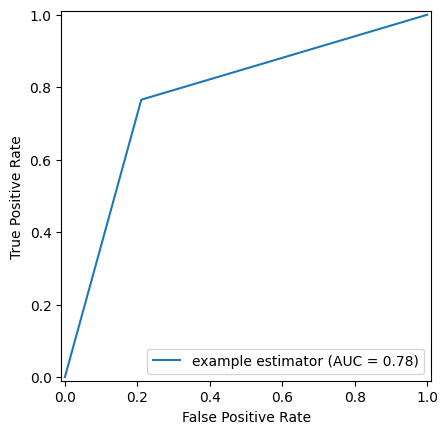

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

Precision - recall curve

Text(0.5, 1.0, 'Precision-Recall curve')

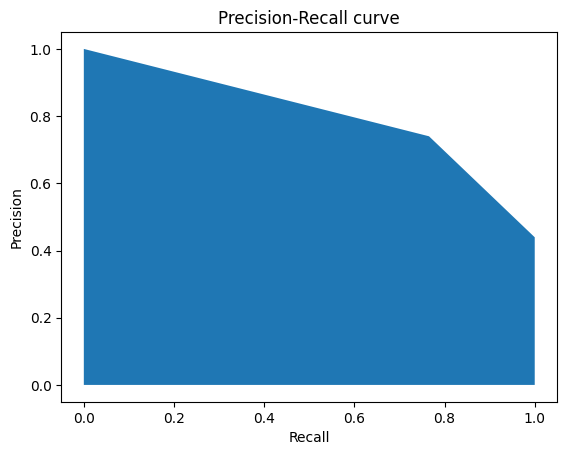

In [27]:
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred)

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve")